## Prerequisites
1. Installing Jupyter Notebook
2. Installing dhSegment (follow the installation procedures and demo steps)
4. Downloading the images data and (optional) the trained 'drop-cap' detection model

## Table of content

1. [Generate the label images](#Generate-label-images)
2. [Show orginal image and generated label](#Show-orginal-image-and-generated-label)
3. [Split data into train and test](#Split-data-into-train-and-test)
4. [Create a `classes.txt` file](#Create-a-classes.txt-file)
5. [Create a config file](#Create-a-config-file)
6. [Train](#train)
7. [Show results on test data](#See-the-results-on-test-data)
8. [Convert into PAGEXML](#Convert-into-PAGE-XML)

In [3]:
from dh_segment.io import PAGE
import numpy as np
import os
from imageio import imread, imsave
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

## Show a few samples

In [ ]:
image_filenames = glob('./images/*.jpg')
plt.figure(figsize=(30,30))
for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(imread(image_filenames[i]))
    plt.axis('off')

## Generate label images

In [ ]:
images_dir = './images/'
export_label_dir = './labels/'
os.makedirs(export_label_dir, exist_ok=True)

In [4]:
list_filenames = glob(os.path.join(images_dir, 'page/*.xml'))

In [5]:
for filename in list_filenames:
    # parse PAGEXML file
    page = PAGE.parse_file(filename)

    # create empty mask ad^nd draw the ornament regions
    mask = np.zeros((page.image_height, page.image_width, 3), dtype=np.uint8)
    page.draw_text_regions(mask, color=(255,0,0), fill=True)

    # save mask
    export_filename = os.path.join(export_label_dir, os.path.basename(page.image_filename).split('.')[0] + '.png')
    
    # save the label image
    imsave(export_filename, mask)

## Show orginal image and generated label

In [6]:
original_image = imread(os.path.join('./images/', page.image_filename))

Text(0.5,1,'Generated label image')

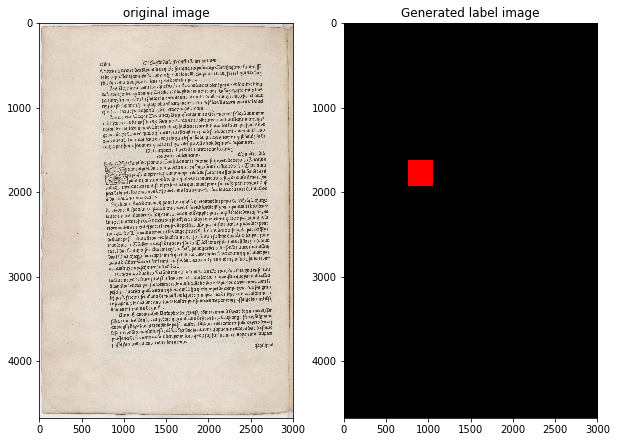

In [7]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title('Generated label image')

## Split data into train and test
You have two options : 
1. (recommended) you modify the already existing `train_data.csv` and `test_data.csv` (used to trained the provided model)
2. you create your train / test data from scratch;

In [8]:
# Get current working directory
dhd_wk_dir = os.getcwd()

#### Option 1: modify the existing csv files

In [9]:
import pandas as pd
import re

In [10]:
train_data = pd.read_csv('./csv/train_data.csv', header=None, names=['images', 'labels'])
eval_data = pd.read_csv('./csv/eval_data.csv', header=None, names=['images', 'labels'])

In [11]:
# show the first 5 entries
train_data[:5]

,images,labels
0,$ROOT_IMAGE_DIR/btv1b86001798_82.jpg,$ROOT_LABEL_DIR/btv1b86001798_82.png
1,$ROOT_IMAGE_DIR/btv1b86001190_45.jpg,$ROOT_LABEL_DIR/btv1b86001190_45.png
2,$ROOT_IMAGE_DIR/btv1b86256422_228.jpg,$ROOT_LABEL_DIR/btv1b86256422_228.png
3,$ROOT_IMAGE_DIR/btv1b86256422_300.jpg,$ROOT_LABEL_DIR/btv1b86256422_300.png
4,$ROOT_IMAGE_DIR/btv1b86000847_94.jpg,$ROOT_LABEL_DIR/btv1b86000847_94.png


In [12]:
abspath_images_dir = os.path.abspath(os.path.join(dhd_wk_dir, images_dir))
abspath_labels_dir = os.path.abspath(os.path.join(dhd_wk_dir, export_label_dir))

In [13]:
train_data['images'] = train_data.images.apply(lambda x: re.sub('\$ROOT_IMAGE_DIR', abspath_images_dir, x))
train_data['labels'] = train_data.labels.apply(lambda x: re.sub('\$ROOT_LABEL_DIR', abspath_labels_dir, x))

eval_data['images'] = eval_data.images.apply(lambda x: re.sub('\$ROOT_IMAGE_DIR', abspath_images_dir, x))
eval_data['labels'] = eval_data.labels.apply(lambda x: re.sub('\$ROOT_LABEL_DIR', abspath_labels_dir, x))

In [14]:
train_data[:5]

,images,labels
0,/scratch/sofia/wk_dhd/images/btv1b86001798_82.jpg,/scratch/sofia/wk_dhd/labels/btv1b86001798_82.png
1,/scratch/sofia/wk_dhd/images/btv1b86001190_45.jpg,/scratch/sofia/wk_dhd/labels/btv1b86001190_45.png
2,/scratch/sofia/wk_dhd/images/btv1b86256422_228...,/scratch/sofia/wk_dhd/labels/btv1b86256422_228...
3,/scratch/sofia/wk_dhd/images/btv1b86256422_300...,/scratch/sofia/wk_dhd/labels/btv1b86256422_300...
4,/scratch/sofia/wk_dhd/images/btv1b86000847_94.jpg,/scratch/sofia/wk_dhd/labels/btv1b86000847_94.png


In [ ]:
train_data.to_csv('./my_train_data.csv', header=False, index=False, encoding='utf8')
eval_data.to_csv('./my_eval_data.csv', header=False, index=False, encoding='utf8')

#### End of option 1: Jump to [next step](#Create-a-classes.txt-file)

#### Option 2: create csv data from scratch

In [ ]:
from random import shuffle
import csv

In [ ]:
data_csv = list()
for filename in list_filenames:
    basename = os.path.basename(filename).split('.')[0]
    image_filename = os.path.abspath(os.path.join(dhd_wk_dir, images_dir, basename + '.jpg'))
    label_filename = os.path.abspath(os.path.join(dhd_wk_dir, export_label_dir, basename + '.png'))
    if os.path.isfile(image_filename) and os.path.isfile(label_filename):
        data_csv.append((image_filename, label_filename))
    else:
        print('did not found correct image / label for filename {}'.format(filename))

In [ ]:
# shuffle data and split in in 0.9 training / 0.1 eval
shuffle(data_csv)
splitting_index = int(np.floor(0.9 * len(data_csv)))
train_data = data_csv[:splitting_index]
eval_data = data_csv[splitting_index:]

In [ ]:
# export data
with open('./my_train_data.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for row in train_data:
        writer.writerow(row)
        
with open('./my_eval_data.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for row in eval_data:
        writer.writerow(row)

## Create a `classes.txt` file
This file contains the color codes for each class

In [15]:
list_colors = [[0, 0, 0],  # black
               [255, 0, 0]] # red

with open('./classes.txt', 'w') as f:
    for color in list_colors:
        [f.write(str(val) + ' ') for val in color]
        f.write('\n')

## Create a config file
This file contains all the parameters that are needed during the training

In [16]:
import json

In [17]:
config = {
  "classes_file": os.path.join(dhd_wk_dir, 'classes.txt'),
  "eval_data": os.path.join(dhd_wk_dir, 'my_eval_data.csv'),
  "train_data": os.path.join(dhd_wk_dir, 'my_train_data.csv'),
  "model_output_dir": os.path.join(dhd_wk_dir, 'exported-model'),
  "prediction_type": "CLASSIFICATION",
  "pretrained_model_name": "resnet50",
  "training_params": {
    "batch_size": 16,
    "data_augmentation": True,
    "data_augmentation_color": True,
    "data_augmentation_flip_lr": True,
    "data_augmentation_flip_ud": True,
    "data_augmentation_max_rotation": 0.2,
    "data_augmentation_max_scaling": 0.3,
    "input_resized_size": 900000,
    "learning_rate": 0.00005,
    "make_patches": True,
    "n_epochs": 20,
    "patch_shape": [
      300,
      300
    ],
    "training_margin": 10
  }
}

assert os.path.isfile(config['classes_file'])
assert os.path.isfile(config['eval_data'])
assert os.path.isfile(config['train_data'])

In [18]:
with open('./config.json', 'w') as f:
    json.dump(config, f, indent=4)

## Train
In order to train the model you should 
1. clone and install dhSegment (intructions [here](https://dhsegment.readthedocs.io/en/latest/start/install.html))
2. download the pretrained weights (step 2. detailed [here](https://dhsegment.readthedocs.io/en/latest/start/demo.html))
3. run `python train.py with <your-path>/config.json`

In [ ]:
"<your-path> is {}".format(dhd_wk_dir)

## Process new data

In [19]:
import tensorflow as tf
from dh_segment.inference import LoadedModel
import pandas as pd

from dh_segment.post_processing import binarization, boxes_detection
from dh_segment.io import PAGE
import cv2
import numpy as np
from glob import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline
from imageio import imread

In [20]:
# Transform probability maps into binary maps
def post_process_probs_ornament(probability_maps):

    binary_maps = np.zeros_like(probability_maps, np.uint8)
    binary_maps = np.delete(binary_maps, 0, 2)

    # Ornament
    binary_image = binarization.thresholding(probability_maps[:, :, 1], threshold=0.5)
    binary_image = binarization.cleaning_binary(binary_image, kernel_size=7)
    boxes = boxes_detection.find_boxes(binary_image, mode='rectangle', min_area=0.)
    bin_map = np.zeros_like(binary_maps)
    binary_maps[:, :, 0] = cv2.fillPoly(bin_map, boxes, (255, 0, 0))[:, :, 0]

    return binary_maps, boxes

In [21]:
def resize_image_coordinates(input_coordinates, input_shape, resized_shape):
    
    rx = input_shape[0] / resized_shape[0]
    ry = input_shape[1] / resized_shape[1]

    return np.stack((np.round(input_coordinates[:, 0] / ry),
                      np.round(input_coordinates[:, 1] / rx)), axis=1).astype(np.int32)

In [22]:
# start a TensorFlow Session with 1 GPU device
session_config = tf.ConfigProto(gpu_options=tf.GPUOptions(visible_device_list="0"))
session = tf.InteractiveSession(config=session_config)

In [23]:
model_directory = './model_ornaments/'

# Load model 
model = LoadedModel(model_directory)

Loading ./model_ornaments/
INFO:tensorflow:Restoring parameters from ./model_ornaments/variables/variables


In [24]:
test_images_dir = './images/test_images/'
filenames_to_process = glob(test_images_dir + '*.jpg')
filenames_to_process

['./images/test_images/btv1b86001494_30.jpg',
 './images/test_images/btv1b8624646d_16.jpg',
 './images/test_images/btv1b55007627b_50.jpg',
 './images/test_images/btv1b86000439_118.jpg',
 './images/test_images/btv1b86000439_133.jpg']

**Example with one image**

In [33]:
example_filename = filenames_to_process[3]

In [34]:
predictions = model.predict(example_filename)
probability_map = predictions['probs'][0]
original_image_shape = predictions['original_shape'] # [H,W] shape

In [35]:
# post-process predictions
binary_map, boxes = post_process_probs_ornament(predictions['probs'][0])
boxes_resized = [resize_image_coordinates(box, 
                                          probability_map.shape[:2], 
                                          original_image_shape) for box in boxes]

Text(0.5,1,'binary')

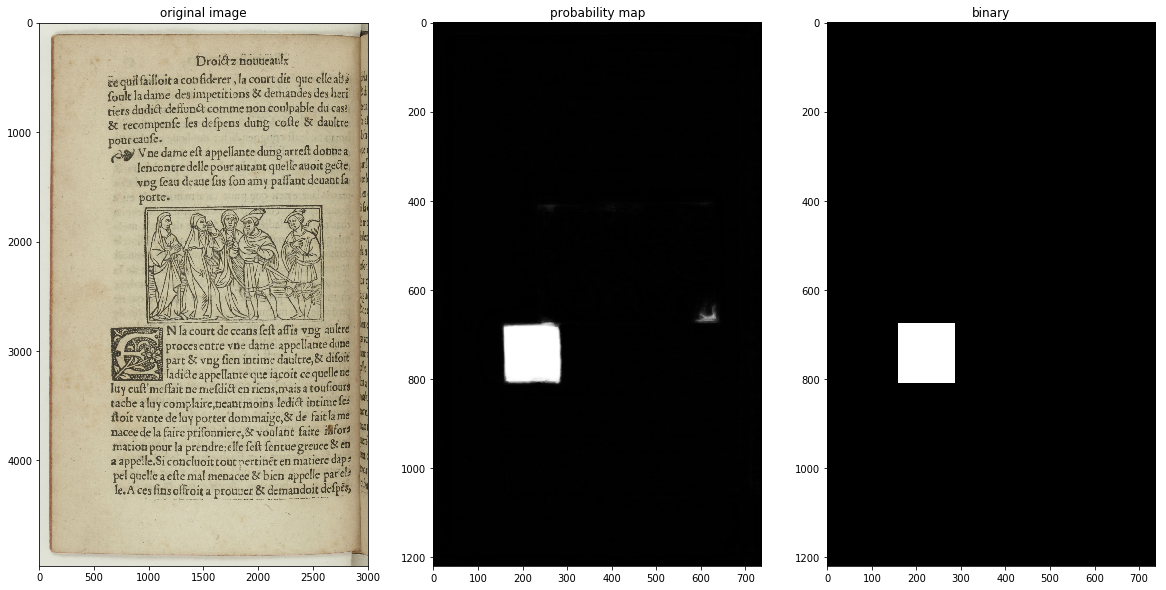

In [36]:
# show example
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(imread(example_filename))
plt.title('original image')
plt.subplot(1,3,2)
plt.imshow(probability_map[:,:,1], cmap='gray')
plt.title('probability map')
plt.subplot(1,3,3)
plt.imshow(binary_map[:,:,0], cmap='gray')
plt.title('binary')

### Export all images detections

In [37]:
new_data_export_dir = os.path.join(test_images_dir, 'page')
os.makedirs(new_data_export_dir, exist_ok=True)

In [ ]:
for filename in filenames_to_process:
    predictions = model.predict(filename)
    probability_map = predictions['probs'][0]
    original_image_shape = predictions['original_shape'] # [H,W] shape
    
    # post-rpocess
    binary_map, boxes = post_process_probs_ornament(predictions['probs'][0])
    boxes_resized = [resize_image_coordinates(box, 
                                              probability_map.shape[:2], 
                                              original_image_shape) for box in boxes]
    
    # export
    text_regions = [PAGE.TextRegion(id='txt-reg-{}'.format(i), 
                                coords=PAGE.Point.array_to_point(coords), 
                                custom_attribute="structure{type:drop-cap;}") for i, coords in enumerate(boxes_resized)]
    
    page = PAGE.Page(image_filename=os.path.basename(filename),
                     image_height=original_image_shape[0],
                     image_width=original_image_shape[1],
                     text_regions=text_regions)

    page.write_to_file(filename=os.path.join(new_data_export_dir, 
                                             os.path.basename(filename).split('.')[0] + '.xml'),
                       creator_name='OrnamentExtractor')

## Process all the eval set

In [38]:
# Get eval data
df_eval = pd.read_csv('./my_eval_data.csv', header=None, names=['images', 'labels'])
filenames_eval = list(df_eval.images.values)

In [39]:
eval_export_dir = './eval_page/'
os.makedirs(eval_export_dir, exist_ok=True)

In [ ]:
for filename in filenames_eval:
    predictions = model.predict(filename)
    probability_map = predictions['probs'][0]
    original_image_shape = predictions['original_shape'] # [H,W] shape
    
    # post-rpocess
    binary_map, boxes = post_process_probs_ornament(predictions['probs'][0])
    boxes_resized = [resize_image_coordinates(box, 
                                              probability_map.shape[:2], 
                                              original_image_shape) for box in boxes]
    
    # export
    text_regions = [PAGE.TextRegion(id='txt-reg-{}'.format(i), 
                                coords=PAGE.Point.array_to_point(coords), 
                                custom_attribute="structure{type:drop-cap;}") for i, coords in enumerate(boxes_resized)]
    
    page = PAGE.Page(image_filename=os.path.basename(filename),
                     image_height=original_image_shape[0],
                     image_width=original_image_shape[1],
                     text_regions=text_regions)

    page.write_to_file(filename=os.path.join(eval_export_dir, 
                                             os.path.basename(filename).split('.')[0] + '.xml'),
                       creator_name='OrnamentExtractor')

## Evaluation

In [40]:
from shapely.geometry import Polygon, MultiPolygon
from dh_segment.io import PAGE

from glob import glob
import os
import numpy as np

In [41]:
gt_xml_dir = './images/page/'
eval_xml_files = glob(eval_export_dir + '*.xml')

In [42]:
list_iou = list()
list_predicted_polygons = list()
list_gt_polygons = list()
for eval_filename in eval_xml_files:
    predicted_page = PAGE.parse_file(eval_filename)
    gt_page = PAGE.parse_file(os.path.join(gt_xml_dir, os.path.basename(eval_filename)))
    
    predicted_polygons = MultiPolygon([Polygon(PAGE.Point.point_to_list(region.coords)) 
                                   for region in predicted_page.text_regions])
    gt_polygons = MultiPolygon([Polygon(PAGE.Point.point_to_list(region.coords)) 
                                for region in gt_page.text_regions])
    
    # Save polygons to visulise them later
    list_predicted_polygons.append(predicted_polygons)
    list_gt_polygons.append(gt_polygons)
    
    iou = predicted_polygons.intersection(gt_polygons).area / predicted_polygons.union(gt_polygons).area
    
    list_iou.append(iou)

In [43]:
np.mean(list_iou)

0.8493676959223133

0.8891844158028637


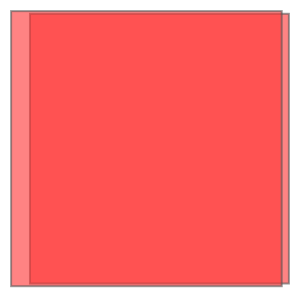

In [75]:
i = 15
print(list_iou[i])
MultiPolygon([*list_predicted_polygons[i], *list_gt_polygons[i]])

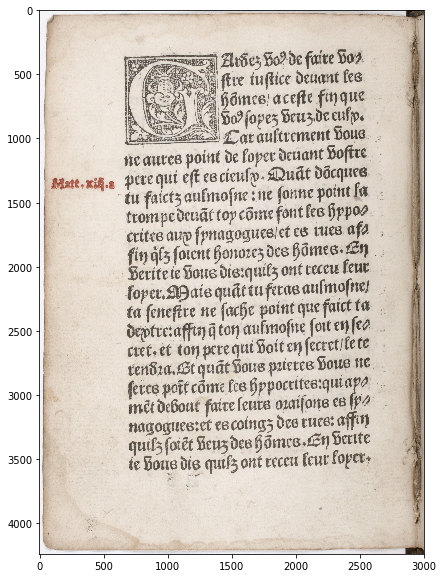

In [73]:
pp = PAGE.parse_file(eval_xml_files[i])
plt.figure(figsize=(10,10))
plt.imshow(imread(os.path.join('./images/', pp.image_filename)))